Dieses Beispiel wurde inspiriert von Tensorflow https://www.tensorflow.org/datasets/keras_example

In [30]:
# Importiert die Bibliotheken Tensorflow, welche für das maschinelle Lernen
# eingesetzt wird, als tf und die Beispieldatensätze als tfds.
import tensorflow as tf
import tensorflow_datasets as tfds

In [31]:
# Als ersten Schritt in der Deeplearning-Pipeline laden wird die Daten
# vom Datensatz und teilt sie in Trainings- und Testdatensätze auf.
# Diese Teilung garantiert, dass das Modell auch auf neue Daten, welche
# es zuvor noch nie gesehen hat, evaluiert werden kann.
(ds_train, ds_test), ds_info = tfds.load(
  'mnist',
  split=['train', 'test'],
  shuffle_files=True,
  as_supervised=True,
  with_info=True,
)

Der MNIST Datensätz enthhält Bilder, in Graustufen, der 10 Zahlen 0,...,9 in Handschrift. Das Ziel ist es meist, den Bildern die richtige Zahl zuzuordnen. Damit befinden wir uns in der Klassifizierung.

In [32]:
# Geben wir die Datensätze aus, erhalten wir mehr Informationen über die Daten.
# Wir wissen nun etwa, dass es sich bei den Bildern um 28 x 28 Pixel handelt.
print(ds_train)
print(ds_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


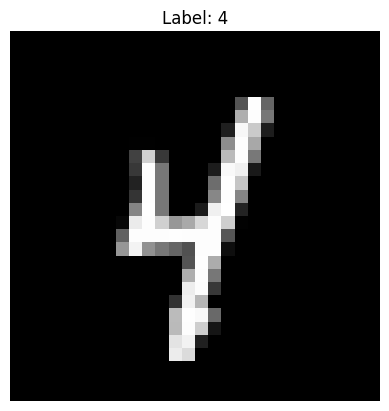

In [33]:
# Schauen wir uns doch einmal eines der Bilder an
import matplotlib.pyplot as plt

# Mit .take können wir n mal aus dem Datensatz ziehen und die Bilder und Labels
# anschließend zum Anzeigen konvertieren und mit Matplotlib ausgeben.
for image, label in ds_train.take(1):
  image = image.numpy()
  label = label.numpy()

  plt.imshow(image, cmap='gray')
  plt.title(f"Label: {label}")
  plt.axis('off')
  plt.show()

In [34]:
# Lass uns nun das ganze Modell laden und eine Zusammenfassung des Models ausgeben.
model = tf.keras.models.load_model('mnist.keras')
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FirstLayer (Dense)              │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLu (Activation)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SecondLayer (Dense)             │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

In [35]:
def crop_and_resize(image, target_size=(28, 28)):
    """
    Konvertiert das Bild zu Schwarz-Weiß, schneidet Ränder weg und bringt es
    in die richtigen Dimensionen.

    Args:
        image (tf.Tensor): Ein zweidimensionaler Tensor,
                          welcher ein Graustufen Bild abbildet (Werte 0-255).
        target_size (tuple): Die gewünschte Bildgröße (default: (28, 28)).

    Returns:
        tf.Tensor: Das verkleinerte, Graustufen Bild in der gewünschten Größe.
    """

    # Suche nach allen Pixeln, die nicht schwarz sind.
    non_zero_pixels = tf.where(image > 0)

    # Suche nach der Boundingbox des Symbols.
    min_row = tf.reduce_min(non_zero_pixels[:, 0])
    max_row = tf.reduce_max(non_zero_pixels[:, 0])
    min_col = tf.reduce_min(non_zero_pixels[:, 1])
    max_col = tf.reduce_max(non_zero_pixels[:, 1])

    # Zuschneiden des Bildes. (Entfernen unnötiger Pixel am Rand.)
    cropped_image = image[min_row:max_row + 1, min_col:max_col + 1]

    # Prüfen, ob das Bild noch Pixel enthält, sonst leeres Bild zurückgeben.
    if tf.size(cropped_image) == 0:
        return tf.zeros(target_size, dtype=tf.uint8)

    # Bild in gewünschte Größe transformieren.
    resized_image = tf.image.resize(
        cropped_image,
        target_size,
        method='bilinear'
    )

    # Entfernen unnötiger Dimensionen.
    resized_image = tf.squeeze(resized_image)

    # Umwandeln des Bildes in Schwarz/Weiß (binär)
    binary_image = tf.where(resized_image > 0, 1, 0)

    return tf.cast(binary_image, tf.uint8)

def normalize_img(image, label):
  """Normalisiert das Bild: `grayscale` -> `black and white`."""
  image = crop_and_resize(image, (28, 28))

  return image, label

Wie wir aus der Zusammenfassung erkennen können handelt es sich bei unserem Modell um ein Modell mit einem Input, einem Hidden und einem Output Layer.
Der Layer Flatten wandelt unser zwei dimensionales Bild in einen eindimensionelen Tensor um.

Die Dense Layer kennen wir als normale Fully-Connected Layer oder vollständig verbundene Schichten. Dabei gibt der Shape-Parameter an wie viel Neuronen sich in der Schicht befinden.

Da wir 10 verschiedene Klassen habe, brauchen wir einen Dense Layer mit 10 Neuronen in der Ausgabeschicht. Dieser hat die Aktivierungsfunktion Softmax, da wir die Wahrscheinlichkeiten der verschiedenen Klassen finden wollen.

In [42]:
# Hier laden wir ein Repository, um das Zeichnen in Colab zu ermöglichen.
!git clone https://gist.github.com/8409b3feec20f159d8a50b0a811d3bca.git

%run /content/8409b3feec20f159d8a50b0a811d3bca/draw.py

draw(filename = "your_drawing.png", w=400, h=400, line_width=64)

fatal: destination path '8409b3feec20f159d8a50b0a811d3bca' already exists and is not an empty directory.


8545

<Figure size 640x480 with 0 Axes>

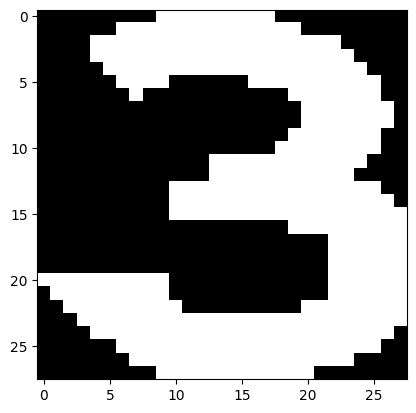

In [43]:
# Nun können wir das Bild laden und es in die richtige Größe transformieren.
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("your_drawing.png", cv2.IMREAD_UNCHANGED)
alpha = img[:, :, 3]
img = np.zeros_like(alpha)
img[alpha > 0] = 255

img = np.expand_dims(img, axis=-1)

# Da der Input des Neuronalen Netzwerkes während des Trainings normalisiert wurde,
# können wir dies auch hier durchführen. [0,255] -> [0; 1]
img, _ = normalize_img(img, 0)

plt.imshow(img, cmap="gray")

In [44]:
import math

# Vorhersagen der richtigen Zahl.
img_exp = np.expand_dims(img, axis=0)
pred = model.predict(img_exp)

# Anzeigen als Balkendiagramm
for i in range(0, 10):
  print(f"{i}: {'■' * int(pred[0][i]*100)} {round(pred[0][i]*100,2)}%")

print("Zahl: ", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
0:  0.0%
1:  0.0%
2:  0.0%
3: ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 99.98999786376953%
4:  0.0%
5:  0.0%
6:  0.0%
7:  0.0%
8:  0.0%
9:  0.0%
Zahl:  3


In [39]:
# Erstellen des Modells basierend auf den Parametern
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28), name="Input"),
  tf.keras.layers.Flatten(name="Flatten"),
  tf.keras.layers.Dense(128, name="FirstLayer"),
  tf.keras.layers.Activation("relu", name="ReLu"),
  tf.keras.layers.Dense(10, name="SecondLayer"),
  tf.keras.layers.Activation("softmax", name="Softmax")
])

# Anzeigen der Zusammenfassung des Modells.
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FirstLayer (Dense)              │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ReLu (Activation)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SecondLayer (Dense)             │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.load_weights("mnist.weights.h5")